In [1]:
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.optimizers import SGD
from keras.layers import Dense,GlobalAveragePooling2D

from keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
/home/lab15/anaconda3/envs/old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lab15/anaconda3/envs/old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lab15/anaconda3/envs/old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lab15/anaconda3/envs/old/l

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
train_datagen = ImageDataGenerator(
                rescale= 1./255,
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.1, # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=False,  # randomly flip images
                vertical_flip=False)

test_datagem = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    'data/train',
                    target_size = (224, 224),
                    batch_size = 128,
                    class_mode = 'categorical')

validation_generator = test_datagem.flow_from_directory(
                    'data/validation',
                    target_size = (224, 224),
                    batch_size = 128,
                    class_mode = 'categorical')

teste_generator = test_datagem.flow_from_directory(
                    'data/teste/',
                    target_size = (224, 224),
                    batch_size = 2976,
                    class_mode = 'categorical')

Found 14286 images belonging to 6 classes.
Found 4464 images belonging to 6 classes.
Found 3570 images belonging to 6 classes.


In [3]:
name = "testeSGD"
tensorbord = TensorBoard(log_dir='logs/{}'.format(name))
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# define checkpoints
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [8]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation

In [9]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [10]:
epochs = 50
sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-2/epochs)

model.compile(optimizer= sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [11]:
model.fit_generator(train_generator,
                    epochs= epochs,
                    steps_per_epoch = 93,
                    validation_steps = 23,
                    validation_data= validation_generator,
                   callbacks=[tensorbord,stop, checkpoint])

Epoch 1/50
93/93 [==============================] - 90s 968ms/step - loss: 1.7432 - acc: 0.2752 - val_loss: 1.6764 - val_acc: 0.6658

Epoch 00001: val_acc improved from -inf to 0.66576, saving model to best_model.h5
Epoch 2/50
93/93 [==============================] - 82s 882ms/step - loss: 1.6461 - acc: 0.8710 - val_loss: 1.6055 - val_acc: 0.9997

Epoch 00002: val_acc improved from 0.66576 to 0.99966, saving model to best_model.h5
Epoch 3/50
93/93 [==============================] - 77s 827ms/step - loss: 1.5863 - acc: 0.9919 - val_loss: 1.5463 - val_acc: 0.9980

Epoch 00003: val_acc did not improve from 0.99966
Epoch 4/50
93/93 [==============================] - 80s 857ms/step - loss: 1.5305 - acc: 0.9907 - val_loss: 1.4903 - val_acc: 0.9990

Epoch 00004: val_acc did not improve from 0.99966
Epoch 5/50
93/93 [==============================] - 79s 853ms/step - loss: 1.4782 - acc: 0.9921 - val_loss: 1.4363 - val_acc: 0.9966

Epoch 00005: val_acc did not improve from 0.99966
Epoch 6/50
93

93/93 [==============================] - 80s 856ms/step - loss: 0.3142 - acc: 0.9998 - val_loss: 0.2941 - val_acc: 0.9993

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
93/93 [==============================] - 79s 853ms/step - loss: 0.3056 - acc: 1.0000 - val_loss: 0.2919 - val_acc: 0.9997

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
93/93 [==============================] - 79s 848ms/step - loss: 0.2985 - acc: 1.0000 - val_loss: 0.2786 - val_acc: 0.9993

Epoch 00047: val_acc did not improve from 1.00000
Epoch 48/50
93/93 [==============================] - 80s 857ms/step - loss: 0.2922 - acc: 1.0000 - val_loss: 0.2765 - val_acc: 0.9997

Epoch 00048: val_acc did not improve from 1.00000
Epoch 49/50
93/93 [==============================] - 79s 851ms/step - loss: 0.2862 - acc: 1.0000 - val_loss: 0.2642 - val_acc: 0.9997

Epoch 00049: val_acc did not improve from 1.00000
Epoch 50/50
93/93 [==============================] - 79s 854ms/step - loss: 0.2775 - ac

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
X = teste_generator.next()
X_test = X[0]
y_test = X[1]

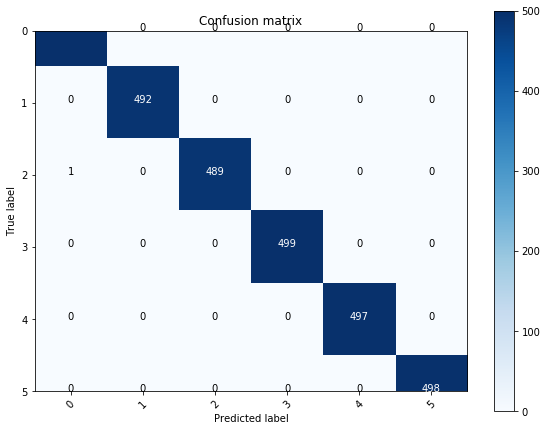

In [23]:
fig= plt.figure(figsize=(8,6))

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6)) 

In [26]:
def acerto(confusion_matrix):
    soma = 0
    for i in range(len(confusion_matrix)):
        soma += confusion_matrix[i][i]
    return soma

In [27]:
soma_acerto = acerto(confusion_matrix)
soma_erro = confusion_mtx[0][1]+confusion_mtx[0][2]+ confusion_mtx[1][0]+confusion_mtx[1][2]+confusion_mtx[2][0]+confusion_mtx[0][1]
total = confusion_mtx.sum()
acc = soma_acerto/total
error = soma_erro/total
acc ,error

TypeError: object of type 'function' has no len()

In [ ]:
soma_acerto